# Time Series Model Generator

In [1]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [25]:
import statsmodels

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Statsmodels version: {statsmodels.__version__}")


NumPy version: 1.24.3
Pandas version: 2.2.2
Statsmodels version: 0.14.0


In [14]:
class TimeSeriesGenerator:
    
    def __init__(self, Nt, Np):
        
        """
        Initialize the time series generator with the number of time steps (Nt) and the number of paths (Np).
        """
        if Nt <= 0 or Np <= 0:
            raise ValueError("Nt and Np must be positive integers.")
        
        self.Nt = Nt
        self.Np = Np
        
    def white_noise(self):
        """
        Generate white noise time series.
        
        Returns:
            np.ndarray: A 2D array of shape (Np, Nt) containing white noise time series.
        """
        return np.random.randn(self.Np, self.Nt)
    
    def MCpaths(self, s0, mu, sigma, dt):
        """
        Generate log returns and convert them to price paths.
        Generate log returns using r=μ⋅dt+z⋅σ⋅sqrt(dt)  where z is a standardized discrete random variable.
        
        Args:
            s0 (float): Initial stock price.
            mu (float): Drift coefficient.
            sigma (float): Volatility coefficient.
            dt (float): Time step size.
            
        Returns:
            np.ndarray: A 2D array of shape (Nt+1, Np) containing the generated price paths.
              
        """
        z = np.random.choice([-1, 1], size=(self.Nt, self.Np))
        r = mu * dt + sigma * z * np.sqrt(dt)
        s = np.zeros((self.Nt + 1, self.Np))
        s[0] = np.log(s0)
        
        for t in range(1, self.Nt + 1):
            s[t] = s[t - 1] + r[t - 1]
        
        price_path = np.exp(s)
        return price_path
    
    
    def gbm(self, mu = 0.07, sigma = 0.15, s_0 = 100.0):
        
        """
        Simulate Geometric Brownian Motion trajectories.
        
        Args:
            mu (float): Annualized drift, e.g., market return.
            sigma (float): Annualized volatility.
            s0 (float): Initial value.
            
        Returns: 
            np.ndarray: A numpy array of Np columns and Nt rows representing the simulated paths.

        """
        dt = 1/self.Nt
        z = np.random.normal(size=(self.Nt, self.Np))
        
        #Calculate the return
        rets = mu * dt + sigma * np.sqrt(dt) * z
        prices = s_0 * (1+rets).cumprod(axis = 0)
        return prices
    
    
    def show_gbm(self, mu = 0.07, sigma = 0.15, s_0 = 100.0):
        """
        Draw the results of a stock price evolution under a Geometric Brownian Motion model
        """

        prices = self.gbm(mu = mu, sigma = sigma, s_0 = s_0)
        prices_df = pd.DataFrame(prices)
        ax = prices_df.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
        ax.axhline(y= s_0, ls=":", color="black", label=f'Initial Price: {s_0}')
        # draw a dot at the origin
        ax.plot(0, s_0, marker='o',color='darkred', alpha=0.2)
     
    
    def AR_model(self, c_0, c_1, c_2):
        """
        Generate autoregressive (AR) model time series up to the second order.
        
        Args:
            c_0, c_1, c_2 (float): Coefficients for the AR model.
            
        Returns:
            np.ndarray: A 2D array of shape (Np, Nt) containing the generated AR time series.
        """
        AR = np.zeros((self.Np, self.Nt))

        for i in range(self.Np):
            r = np.zeros(self.Nt)
            z = np.random.randn(self.Nt)
            for t in range(2, self.Nt):
                r[t] = c_0 + c_1 * r[t-1] + c_2 * r[t-2] + z[t]
        
            AR[i, :] = r
        return AR
    
    def MA_model(self, t_1, t_2):
        """
        Generate moving average (MA) model time series up to the second order.
        
        Args:
            t_1, t_2 (float): Coefficients for the MA model.
            
        Returns:
            np.ndarray: A 2D array of shape (Np, Nt+2) containing the generated MA time series.
        """
    
        MA = np.zeros((self.Np, self.Nt))

        for i in range(self.Np):
            x = np.zeros(self.Nt)
            epsilon = np.random.randn(self.Nt)  
            x[0] = epsilon[0]
            x[1] = epsilon[1] + t_1 * epsilon[0]
            
            for t in range(2, self.Nt):
                x[t] =epsilon[t]+ t_1* epsilon[t-1] + t_2 * epsilon[t-2] 

            MA[i, :] = x
            
        return MA
    
    
    def plot_generated_paths(self, time_model, model_type=""):
        
        """
        Plot the generated time series paths.
        
        Args:
            time_model (np.ndarray): The time series data to plot.
            model_type (str): The model type name to be included in the plot title.
        """
        if time_model.shape != (self.Np, self.Nt):
            raise ValueError(f"Expected shape ({self.Np}, {self.Nt}), got {time_model.shape}.")
        
        plt.figure(figsize=(12, 6))
        for i in range(min(self.Np, 10)):
            plt.plot(time_model[i], label=f'Path {i+1}')
        
        plt.title(f"Generated Time Series Paths for {model_type}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

        fig, axs = plt.subplots(4, 3, figsize=(16, 18))
        for i in range(min(self.Np, 4)):
            axs[i, 0].plot(np.cumsum(time_model[i,:]))
            axs[i, 0].set_title(f'Generated Time Series Path for {i+1}')
            plot_acf(time_model[i, :], ax=axs[i, 1], lags=30)
            plot_pacf(time_model[i, :], ax=axs[i, 2], lags=30)
            
        plt.tight_layout()
        plt.show()
        


### Generate White Noise

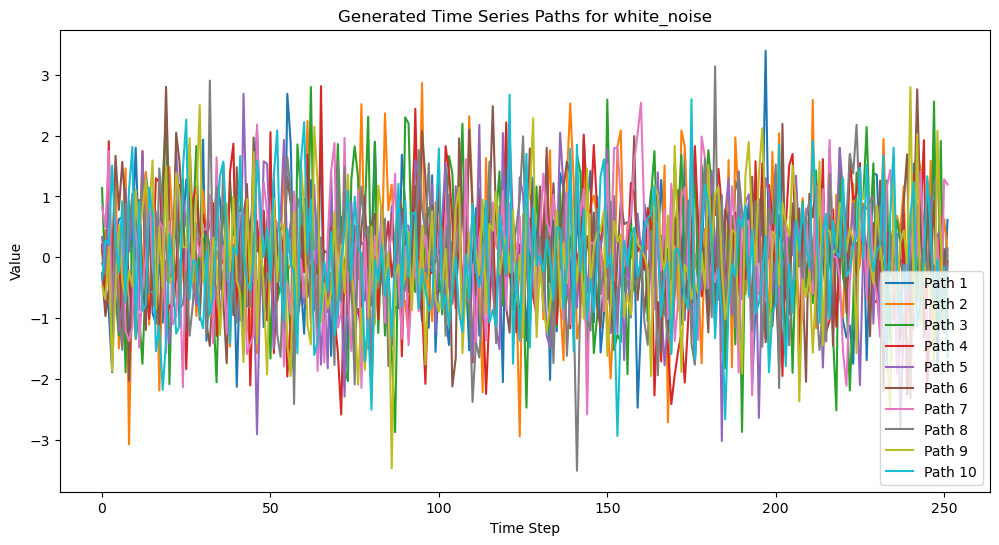

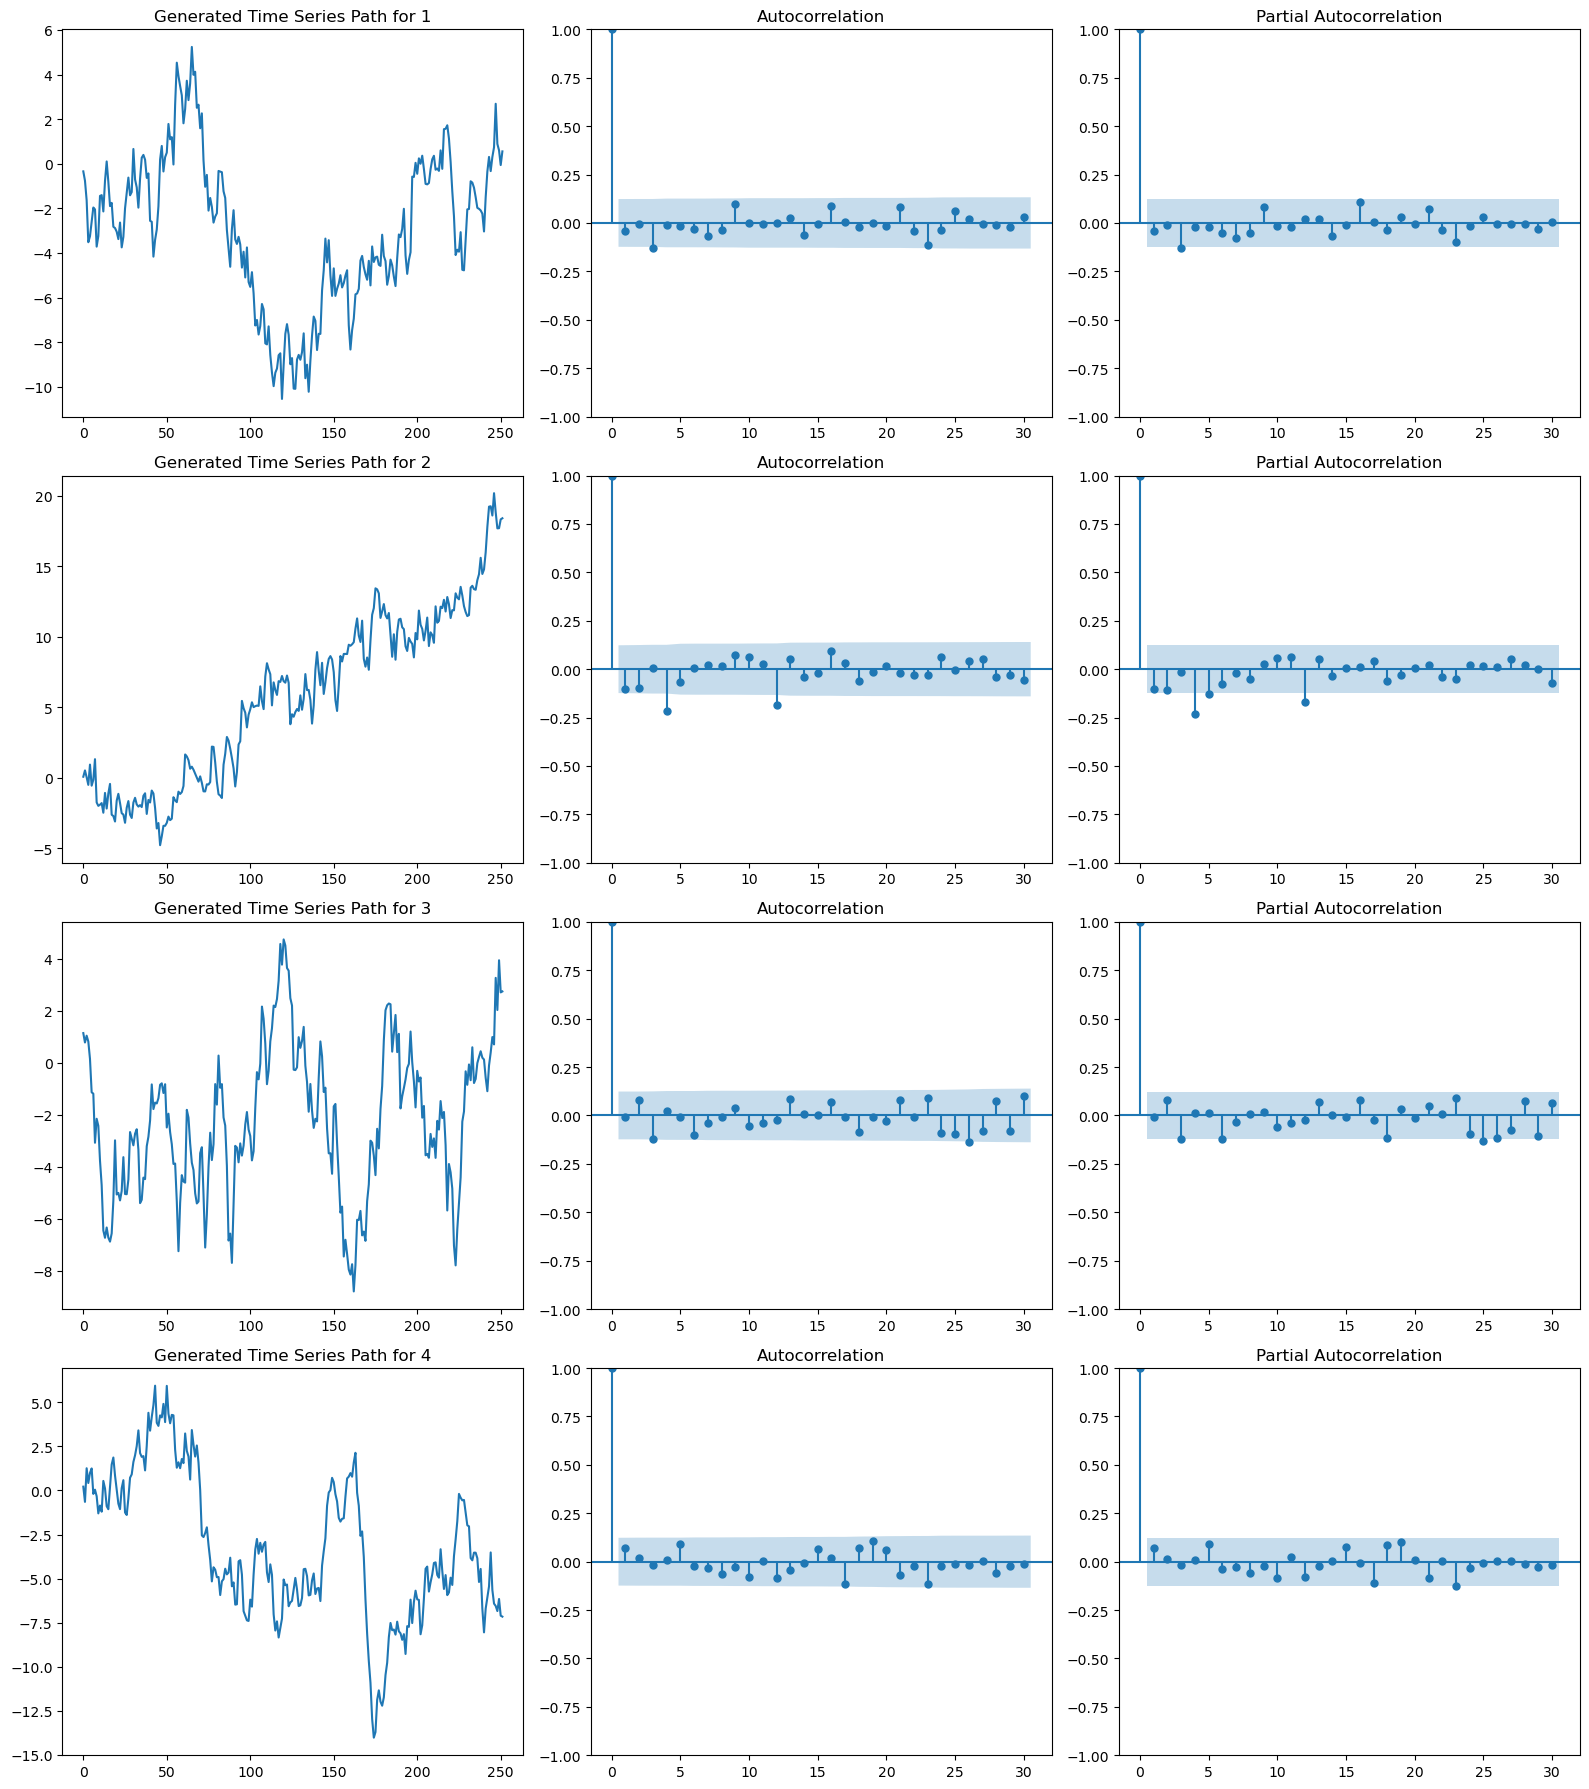

In [5]:
generator = TimeSeriesGenerator(Nt = 252, Np = 10000)
white_noise = generator.white_noise()
generator.plot_generated_paths(white_noise, model_type= "white_noise")

In [6]:
generator = TimeSeriesGenerator(Nt = 252, Np = 10000)
price_path = generator.MCpaths(s0 = 100, mu = 0.06, sigma = 0.4, dt = 1/252)
terminal_values = price_path[-1]
mean = np.mean(terminal_values)
std = np.std(terminal_values)
print(f"The mean {mean:.3f} and standard deviation {std:.3f}")

The mean 115.151 and standard deviation 47.716


### Interactive Simulation of GBM

In [17]:
import ipywidgets as widgets
from IPython.display import display

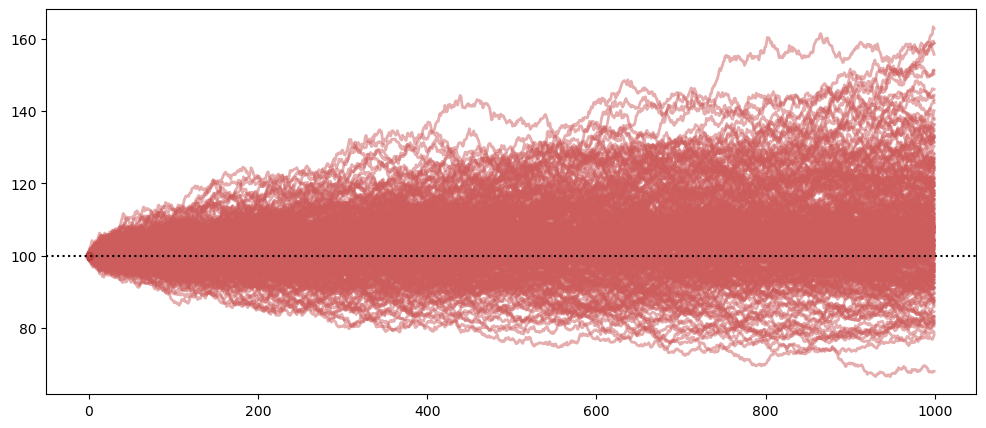

In [18]:
Nt = 1000  # Number of time steps
Np = 252   # Number of paths
ts_generator = TimeSeriesGenerator(Nt, Np)

# Generate GBM paths
gbm_paths = ts_generator.gbm(mu=0.07, sigma=0.15)
ts_generator.show_gbm()

In [19]:
gbm_controls = widgets.interactive(
    ts_generator.show_gbm,
    n_scenarios=widgets.IntSlider(min=1, max=100, step=1, value=1), 
    mu=widgets.FloatSlider(min=0., max=.2, step=.01, value=0.07),
    sigma=widgets.FloatSlider(min=0, max=.3, step=.01, value=0.15)
)

# Display the interactive plot
display(gbm_controls)

interactive(children=(FloatSlider(value=0.07, description='mu', max=0.2, step=0.01), FloatSlider(value=0.15, d…

### Simulating Moving Average Model

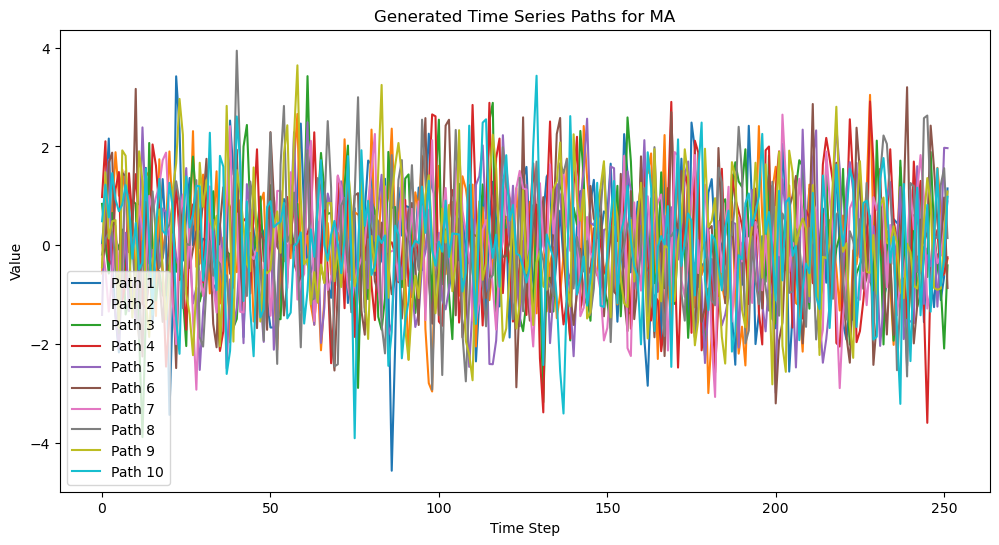

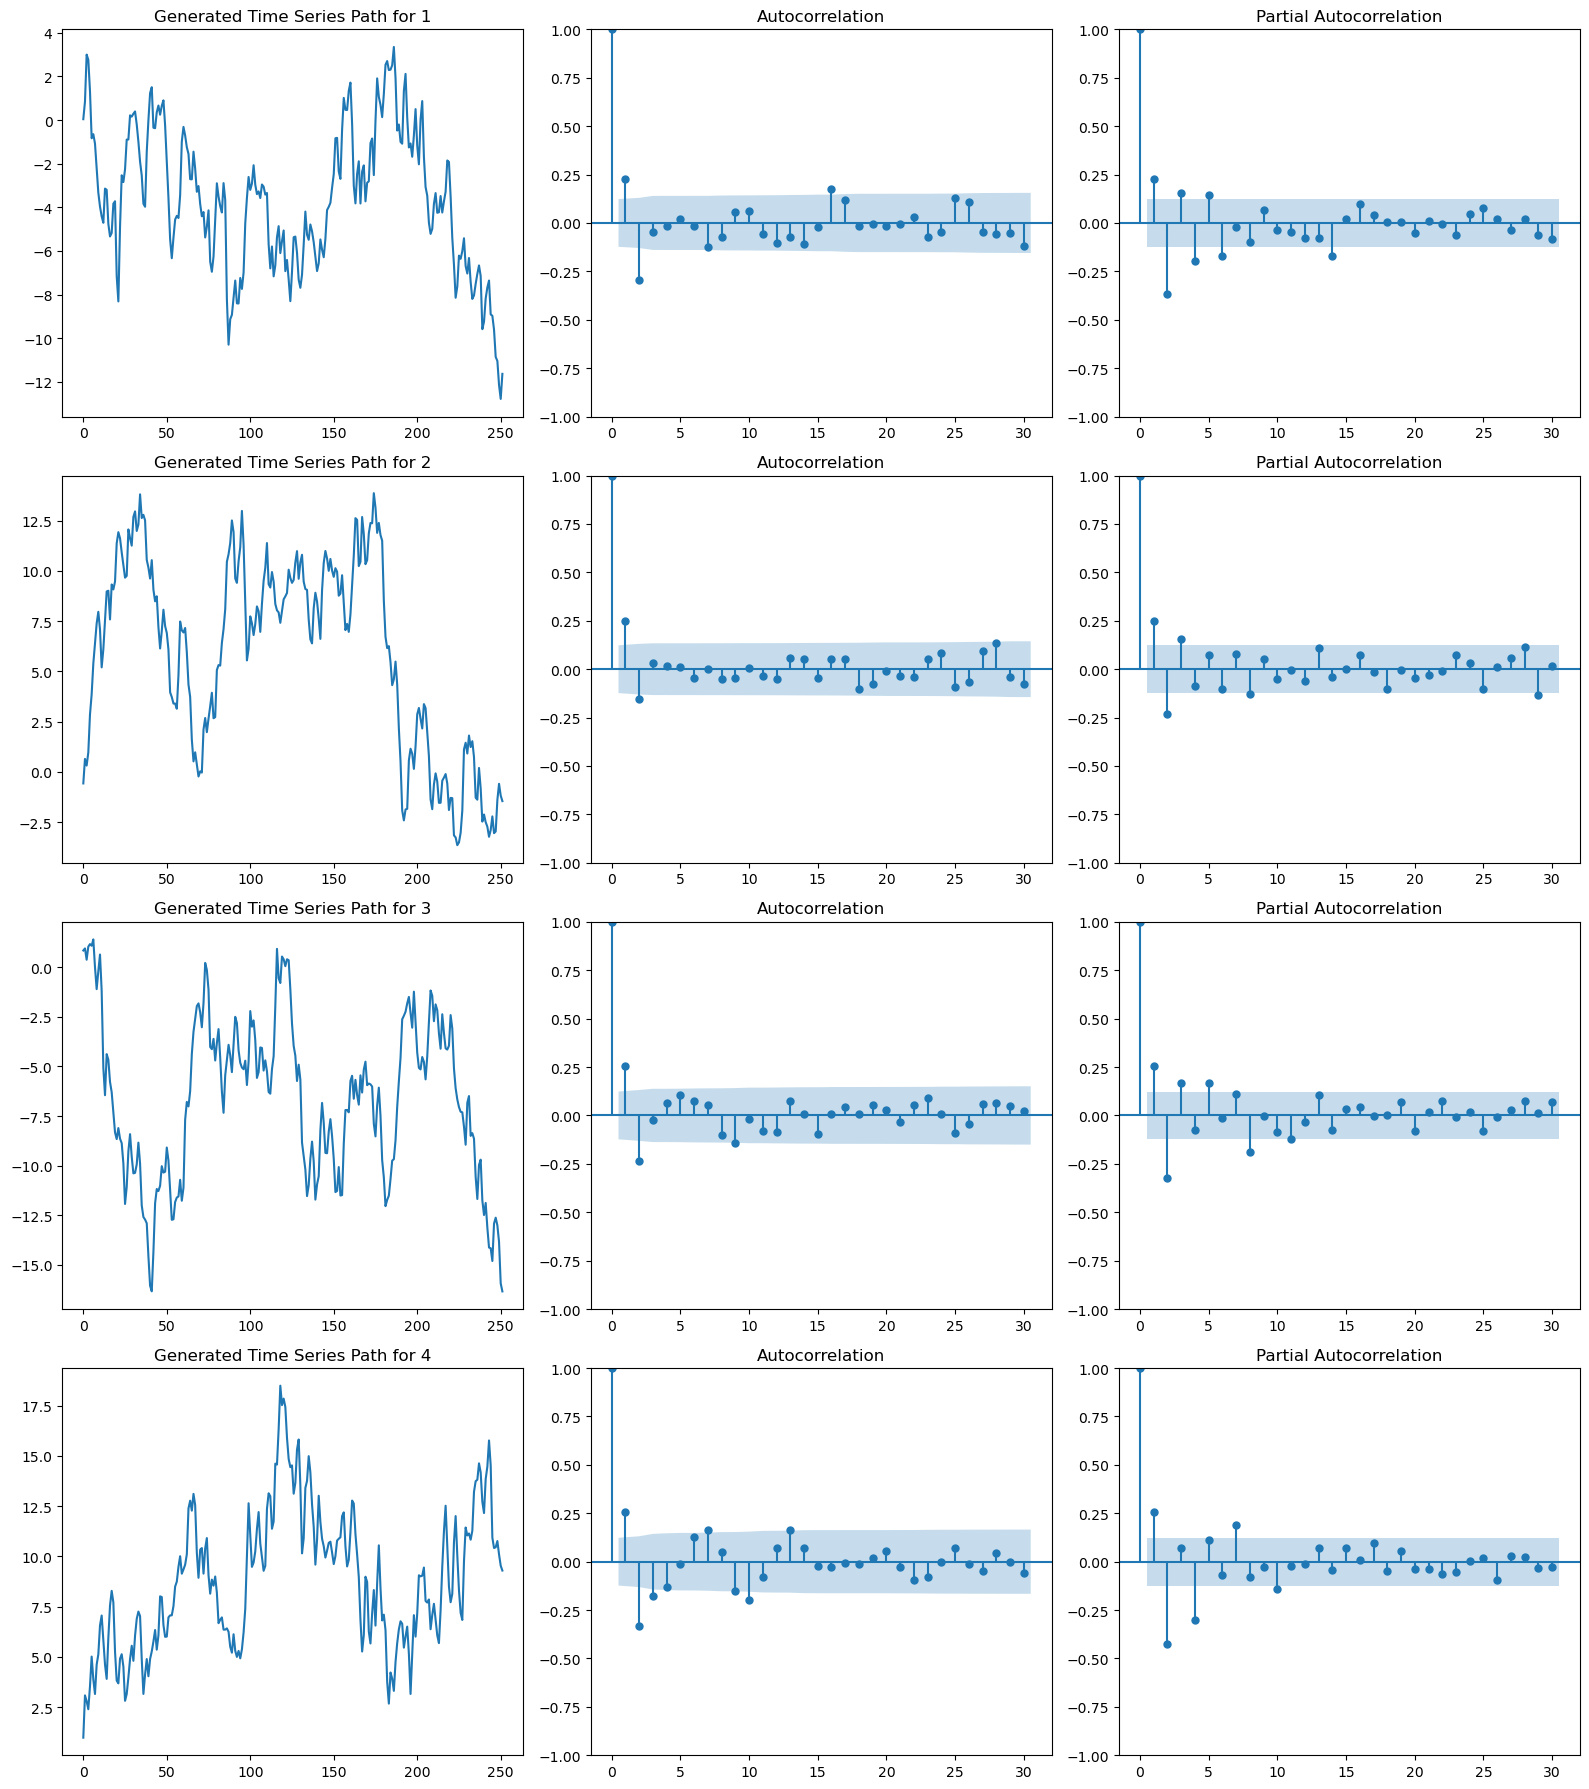

In [20]:
generator = TimeSeriesGenerator(Nt = 252, Np = 1000)
MA = generator.MA_model(0.5, -.3)
MA.shape
generator.plot_generated_paths(MA, model_type= "MA")